<a href="https://colab.research.google.com/github/Plumz17/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Third Digital Image Processing Assignment
##Analysis of Morphological Processing Methods - Anders Emmanuel Tan (24/541351/PA/22964)
Description: Pada Assignment ini, saya akan membandingkan dan menganalisis keempat metode sederhana Morphological Processes, termasuk:

*   Dilation
*   Erotion
*   Opening
*   Closing

serta mengimplementasikan Otsu Segmentation pada citra-citra tersebut.

## 1. Setting Up Image to be Processed
Description: Pada Bagian Pertama Ini, kita akan mempersiapkan Citra-citra yang akan diproses nanti. Karena File yang diupload pada google colab hanya tersedia pada runtime, kita dapat mengunduh file tersebut dengan menyalin file pada Github Submission. Selain itu, kita dapat mengimpor library yang akan dipakai dan mengimpor juga citra-citra yang masing-masing disimpan pada sebuah variabel setelah diubah color mapnya menjadi monochrome agar pengolahan citra lebih mudah. Kemudian, kita dapat mempersiapkan sebuah function pembantu untuk membantu melihat perbandingan hasil citra dengan citra asli. Selain itu, kita dapat menambahkan fungsi Negative Image (dari assignment sebelumnya) agar yang disegmentasi pada proses Image Segmentation dapat berupa foreground citra tersebut.

In [247]:
#Cloning Github Repository to get the Image
!rm -rf PCD_Assignment03
!git clone https://github.com/Plumz17/PCD_Assignment03

Cloning into 'PCD_Assignment03'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 2.62 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [248]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math

filename = "/content/PCD_Assignment03/img.png"
filename_dilation = "/content/PCD_Assignment03/dilation.png"
filename_erosion = "/content/PCD_Assignment03/erosion.png"
filename_opening = "/content/PCD_Assignment03/opening.png"
filename_closing = "/content/PCD_Assignment03/closing.png"


img_dilate_ori = cv2.imread(filename_dilation) # Read Image
img_dilate_ori  = cv2.cvtColor(img_dilate_ori , cv2.COLOR_BGR2GRAY) # Change the color map

img_erosion_ori  = cv2.imread(filename_erosion) # Read Image
img_erosion_ori  = cv2.cvtColor(img_erosion_ori , cv2.COLOR_BGR2GRAY) # Change the color map

img_opening_ori  = cv2.imread(filename_opening) # Read Image
img_opening_ori  = cv2.cvtColor(img_opening_ori , cv2.COLOR_BGR2GRAY) # Change the color map

img_closing_ori  = cv2.imread(filename_closing) # Read Image
img_closing_ori  = cv2.cvtColor(img_closing_ori , cv2.COLOR_BGR2GRAY) # Change the color map

In [249]:
def show(before, segmented=None, processed=None, title1="Original", title2="Segmented", title3="Processed"): # Helper function to check the before and after of the enhancement
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,3,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show segmented
  plt.subplot(1,3,2)
  plt.imshow(segmented, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  # Show processed
  plt.subplot(1,3,3)
  plt.imshow(processed, cmap='gray', vmin=0, vmax=255)
  plt.title(title3)
  plt.axis("off")

  plt.show()

In [250]:
def negative(img): ## Negative Image
  out = img.copy()
  L = 256 # max pixel
  for i in range(out.shape[0]): #Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = L - 1 - out[i][j] # Use the formula s = (L - 1) - r, where L is 256 so s = 255 - r
  return out

img_dilate = negative(img_dilate_ori)
img_erosion = negative(img_erosion_ori)
img_opening = negative(img_opening_ori)
img_closing = negative(img_closing_ori)

## 2. Image Segmentation (Otsu's Thresholding)
Description: Untuk membuat segmentasi lebih adaptif, kita dapat menggunakan metode Otsu Thresholding untuk mencari Threshold optimal pada suatu cita. Hal tersebut dapat diperoleh dengan menghitung bobot, rerata, serta variansi intensitas pixel pada suatu citra dan kemudian menghitung Within Class Invariance dari Citra tersebut. Terakhir, kita dapat memilih Threshold dengan Within Class Invariance terkecil untuk dijadikan threshold optimal citra tersebut.

In [251]:
def find_otsu_threshold(image):
  hist, bins = np.histogram(image.flatten(), 256, [0, 256]) #Make the PDF of the histogram
  totalPixel = image.size
  normilizedProb = hist / totalPixel # Normalize the histogram for easier calculation
  intensityLevels = np.arange(256)
  #Define used variables to minimize WCI
  minVariance = float("inf")
  optimalTreshold = 0

  #Loop over every single Threshold from 0 to 255
  for T in range(256):
    #Calculate Weight, Mean, and Variance of background
    wb = np.sum(normilizedProb[:T + 1])
    if wb == 0:
      continue
    meanb_up = np.sum(intensityLevels[:T + 1] * normilizedProb[:T + 1])
    meanb = meanb_up / wb
    varianceb_up = np.sum(normilizedProb[:T + 1] * (intensityLevels[:T + 1] - meanb)**2)
    varianceb = varianceb_up / wb

    #Calculate Weight, Mean, and Variance of foreground
    wf = np.sum(normilizedProb[T + 1:])
    if wf == 0:
      break

    meanf_up = np.sum(intensityLevels[T + 1:] * normilizedProb[T + 1:])
    meanf = meanf_up / wf
    variancef_up = np.sum(normilizedProb[T + 1:] * (intensityLevels[T + 1:] - meanf)**2)
    variancef = variancef_up / wf

    #Use Otsu Method Formula
    within_class_variance = wb * varianceb + wf * variancef

    #Override Threshold if more otpimal
    if within_class_variance < minVariance:
      minVariance = within_class_variance
      optimalTreshold = T
  return optimalTreshold

In [252]:
def segment(image, threshold = 128):
  segmented_image = np.zeros(image.shape, dtype = np.uint8)
  row, col = image.shape

  for r in range(row):
    for c in range(col):
      if image[r,c] > threshold:
        segmented_image[r,c] = 255
      else:
        segmented_image[r,c] = 0

  return segmented_image

## 3. Morphological Processes


###3A. Dilation
Description: Setelah kita mensegment citra yang akan kita gunakan, kita dapat melakukan morphological processes untuk membuat citra-citra lebih mudah diproses oleh sistem. Metode pertama yang akan dibahas adalah Dilatasi. Dilatasi bertujuan untuk memperbesar area foreground pada suatu citra biner. Proses tersebut melibatkan sebuah kernel yang menambahkan piksel pada tepi objek apabila ada piksel foreground yang overlap dengan kernel tersebut. Salah satu kasus yang dapat memanfaatkan metode ini adalah untuk optical character recognition pada suatu historical document yang banyak memiliki piksel-piksel yang terputus. Kita dapat menggunakan Dilasi untuk memastikan bahwa setiap karakter telah disegmentasikan menjadi hanya satu bagian seperti yang dilihat pada contoh dibawah.

Optimal Threshold: 72


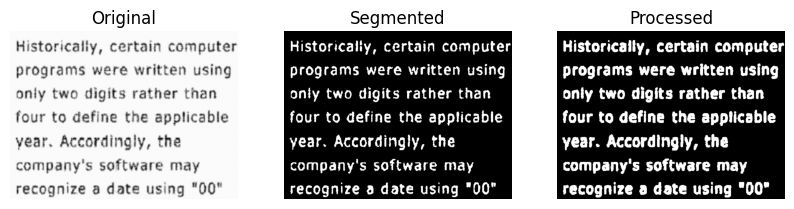

In [253]:
def dilate(img, kernel_size = 3):
  rows, cols = img.shape
  dilated = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.any(region * kernel): #If region and kernel overlapped change background to foreground
        dilated[i, j] = 255
  return dilated

optimal_threshold = find_otsu_threshold(img_dilate)
print(f"Optimal Threshold: {optimal_threshold}")
img_dilate = segment(img_dilate, optimal_threshold)
dilated_img = dilate(img_dilate, 3)
show(img_dilate_ori, img_dilate, dilated_img)


###3B. Erosion
Description: Selain metode Dilasi, kita sekarang akan membahas metode Erosi. Erosi merupakan kebalikan dari Erosi, ia bertujuan untuk memperkecil atau mengikis area foreground pada suatu citra biner. Seperti Dilasi, Proses tersebut juga melibatkan sebuah kernel. Namun, tidak seperti Dilasi, sebuah piksel foreground tidak akan diubah menjadi background jika seluruh elemen pada kernel tersebut berada diatas piksel foreground. Salah satu kasus yang dapat memanfaatkan metode ini adalah untuk menghitung jumlah objek pada suatu citra. Hal tersebut sangat membantu jika objek pada citra tersebut bersentuhan (seperti pada citra dibawah) yang menyebabkan komputer mengsegmentasi beberapa objek menjadi satu sehingga perhitungan akan tidak akurat. Pada hasil erosi, kita dapat melihat bahwa objek-objek pada citra dibawah dapat dipisah setelah dilakukan erosi.

Optimal Threshold: 157


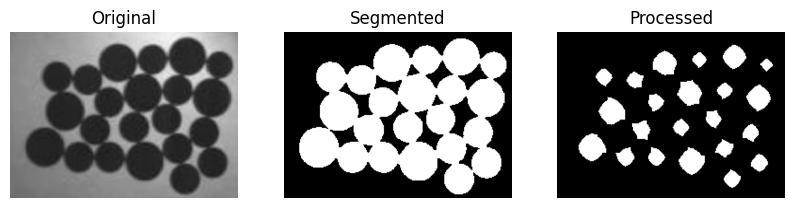

In [254]:
def erode(img, kernel_size = 3):
  rows, cols = img.shape
  eroded = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.all(region * kernel == 255): #Change foreground to background if region is not in all of kernel
        eroded[i, j] = 255
      else:
        eroded[i, j] = 0
  return eroded

optimal_threshold = find_otsu_threshold(img_erosion)
print(f"Optimal Threshold: {optimal_threshold}")
img_erosion = segment(img_erosion, optimal_threshold)
eroded_img = erode(img_erosion, 25)
show(img_erosion_ori, img_erosion, eroded_img)


###3C. Opening
Description: Seletah kita membahas Erosi dan Dilasi, kita dapat menggabungkan kedua metode tersebut. Pada metode Opening, kita akan melakukan erosi yang diikuti oleh dilasi. Tujuan utama dari metode ini adalah untuk menghilangkan noise atau objek-objek yang kecil pada suatu citra tanpa terlalu mengubah bentuk atau ukuran objek utama. Pada Fase Erosi, program akan menghilangkan noise dan piksel-piksel kecil pada citra. Kemudian pada fase Dilasi, program akan mengembalikan ukuran pada objek-objek utama yang telah dikikis pada fase erosi sehingga objek tersebut tidak mengecil. Kita dapat melihat pada contoh implementasi dibawah bahwa algoritma berhasil menghilangkan sel-sel kecil sementara sel yang besar dapat bertahan.

Optimal Threshold: 55


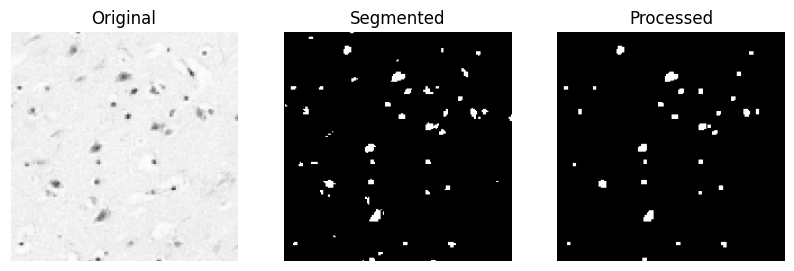

In [255]:
def opening(img, kernel_size = 3):
  eroded = erode(img, kernel_size)
  opened = dilate(eroded, kernel_size)
  return opened

optimal_threshold = find_otsu_threshold(img_opening)
print(f"Optimal Threshold: {optimal_threshold}")
img_opening = segment(img_opening, optimal_threshold)
opened_img = opening(img_opening, 3)
show(img_opening_ori, img_opening, opened_img)

###3D. Closing
Description: Setelah kita mengimplementasikan Opening, kita akan membahas metode kebalikannya yaitu Closing. Sebaliknya Opening, Closing melakukan dilasi dahulu, yang kemudian diikuti oleh Closing. Tujuan utama metode ini adalah menutupi lubang-lubang yang tersisa pada proses segmentasi. Pada proses dilasi, program akan menutupi celah-celah pada objek dan setelah itu ukuran objek akan dikembalikan menjadi ukuran awal sehingga pada dasarnya, program hanya menutupi celah-celah yang terbentuk. Hasil proses tersebut membuat objek menjadi menyatu dan utuh. Kita dapat melihat contoh dibawah untuk lebih memperjelasan penjelasan saya. Bisa dilihat bahwa refleksi pada objek dibawah terhitung sebagai background pada proses segmentasi. Namun, ketika kita menerapkan closing pada citra tersebut, kita dapat menutup celah yang disebabkan oleh refleksi tersebut sehingga pada hasil akhirnya hanya terdapat satu objek yang utuh tanpa adanya lubang.

Optimal Threshold: 124


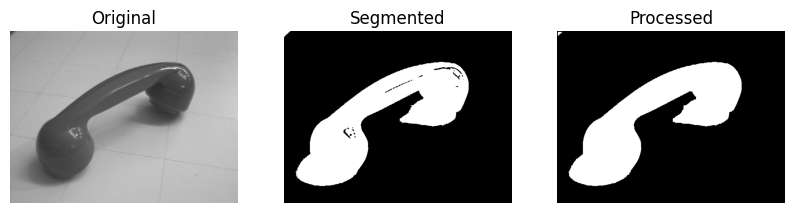

In [256]:
def closing(img, kernel_size = 3):
  dilated = dilate(img, kernel_size)
  closed = erode(dilated, kernel_size)
  return closed

optimal_threshold = find_otsu_threshold(img_closing)
print(f"Optimal Threshold: {optimal_threshold}")
img_closing = segment(img_closing, optimal_threshold)
closed_img = closing(img_closing, 5)
show(img_closing_ori, img_closing, closed_img)